In [1]:
import torch

import math
import random
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import networkx as nx
import matplotlib.pyplot as plt

from agent_functions import bellman_update_q_table, e_greedy_select_action
import numpy as np

from run_functions import *
import copy

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Sandbox ...

In [86]:
S = np.zeros(10)
T = np.ones(10)
t = np.random.random(size=10)
t

array([0.0474443 , 0.5264661 , 0.79865217, 0.04280254, 0.84591677,
       0.17611129, 0.91598163, 0.334485  , 0.7380481 , 0.95869512])

In [83]:
b = np.where(S != T, True, False)
b

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [85]:
a = np.where(t == t[b].min()) 
a

(array([1]),)

{0: Text(0, 1, '0'),
 1: Text(1, 2, '1'),
 2: Text(1, 0, '2'),
 3: Text(2, 1, '3'),
 4: Text(1.5, 0, '4')}

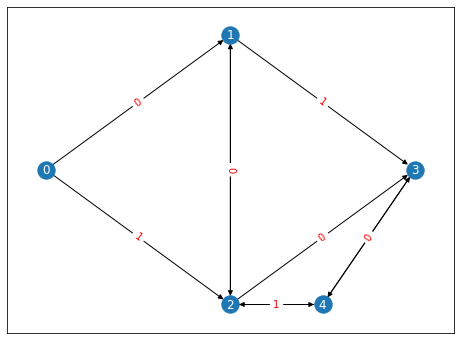

In [34]:
n_agents = 100
n_actions = 2
n_states = 4
n_iter = 1000

G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([
    (0, 1, {"cost": lambda x: x}), 
    (0, 2, {"cost": lambda x: 100}),
    (1, 2, {"cost": lambda x: 0}),
    (2, 1, {"cost": lambda x: 0}),
    (1, 3, {"cost": lambda x: 100}),
    (2, 3, {"cost": lambda x: x}),
    (2, 4, {"cost": lambda x: 50+x}),
    (4, 2, {"cost": lambda x: 50+x}),
    (4, 3, {"cost": lambda x: x}),
    (3, 4, {"cost": lambda x: x})
])
positions = {0: (0, 1), 1: (1,2), 2: (1,0), 3: (2,1), 4: (1.5, 0)}
fig, ax = plt.subplots(figsize=(8,6))
nx.draw_networkx_edges(G, pos=positions, ax=ax)
nx.draw_networkx_nodes(G, pos=positions, ax=ax)
nx.draw_networkx_edge_labels(G, pos=positions, ax=ax, 
                            edge_labels={
                                (0, 1): "0", 
                                (0, 2): "1",
                                (1, 2): "0",
                                (1, 3): "1",
                                (2, 3): "0",
                                (2, 4): "1",
                                (4, 3): "0"
                            }, font_color="red")
nx.draw_networkx_labels(G, pos=positions, ax=ax, font_color="white")

In [41]:
s0 = torch.tensor([i%4 for i in range(n_agents)])
s_terminal = torch.tensor([4 for i in range(n_agents)])

In [42]:
s0, s_terminal

(tensor([0, 1, 2]), tensor([4, 4, 4]))

In [40]:
n_states = 5
n_agents = 3

In [43]:
tmp = torch.empty((n_agents, n_states))
tmp[range(n_agents), s0] = 1

In [44]:
tmp

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])

### ... end of Sanbox

In [208]:
n_agents = 100
n_actions = 2
n_states = 4
n_iter = 1000

G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([
    (0, 1, {"cost": lambda x: x}), 
    (0, 2, {"cost": lambda x: 100}),
    (1, 2, {"cost": lambda x: 0}),
    (1, 3, {"cost": lambda x: 100}),
    (2, 3, {"cost": lambda x: x}),
    (2, 4, {"cost": lambda x: 50+x}),
    (4, 3, {"cost": lambda x: x})
])

positions = {0: (0, 1), 1: (1,2), 2: (1,0), 3: (2,1), 4: (1.5, 0)}

<IPython.core.display.Javascript object>


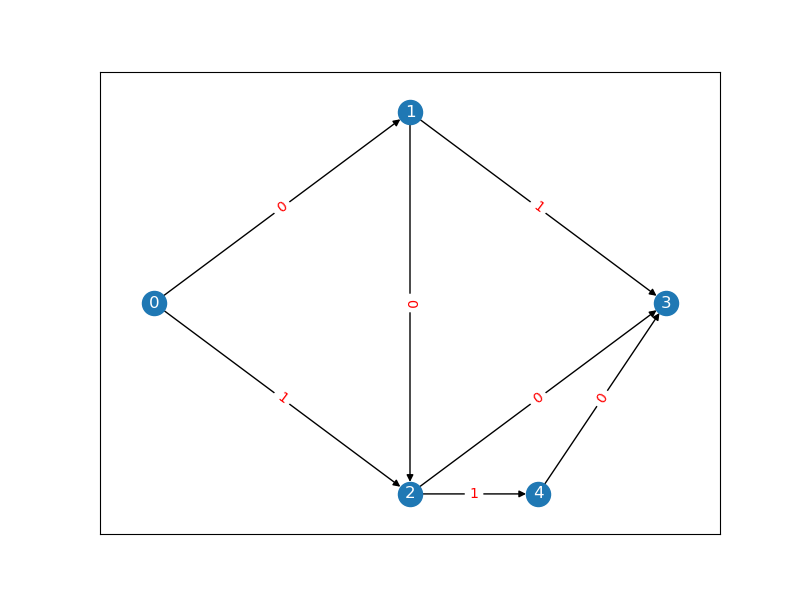

{0: Text(0, 1, '0'),
 1: Text(1, 2, '1'),
 2: Text(1, 0, '2'),
 3: Text(2, 1, '3'),
 4: Text(1.5, 0, '4')}

In [210]:
# subax1 = plt.subplot(121, size=(8,6))
fig, ax = plt.subplots(figsize=(8,6))
nx.draw_networkx_edges(G, pos=positions, ax=ax)
nx.draw_networkx_nodes(G, pos=positions, ax=ax)
nx.draw_networkx_edge_labels(G, pos=positions, ax=ax, 
                            edge_labels={
                                (0, 1): "0", 
                                (0, 2): "1",
                                (1, 2): "0",
                                (1, 3): "1",
                                (2, 3): "0",
                                (2, 4): "1",
                                (4, 3): "0"
                            }, font_color="red")
nx.draw_networkx_labels(G, pos=positions, ax=ax, font_color="white")

In [198]:
# Q = initialize_q_table("UNIFORM", n_agents, n_states, n_actions)
Q = - np.random.random_sample(size=(n_agents, n_states, n_actions))*50 - 50
alpha = initialize_learning_rates(0.1, n_agents)
epsilon = initialize_exploration_rates(0.1, n_agents)
data = {}
ind = np.arange(n_agents)

epsilons = np.linspace(1, 0, n_iter)
# epsilons = np.ones(n_iter)*0.2

for t in range(n_iter):
    T = np.zeros(n_agents)
    S = np.zeros(n_agents).astype(int)
    actions_taken = np.zeros((n_states, n_actions))
    trajectory = []
    
    while np.where(S==3, False, True).sum() > 0:
        remaining_agents = np.where(S!=3, True, False)
        next_agents = np.where(T == T[remaining_agents].min(), True, False)
        
        uni = np.unique(S[next_agents])
        
        for s in uni:
            if s == 3:
                # terminate
                pass
            else:    
                edges = [neighbour[1] for neighbour in G.edges(s)]
                
                agents_at_s = np.where(S==s, True, False) * next_agents
                
                A = e_greedy_select_action(Q[agents_at_s], S[agents_at_s], epsilons[t])
                
#                 print(A)
                
                A = np.clip(A.flatten(), 0, len(edges)-1)
                
#                 print(A)
                
                counts = np.bincount(A, minlength=n_actions)
                
                actions_taken[s] += counts
#                 print(actions_taken)
                rewards = [G.adj[s][neighbour[1]]["cost"](counts[i]) for i,neighbour in enumerate(G.edges(s))]

        
                R = np.array([rewards[a] for a in A])
                            
#                 r_average = np.array(rewards).mean()
#                 R = np.array([r_average for a in A])
                
                S[agents_at_s] = np.array([edges[a] for a in A]).astype(int)
                
                all_belief_updates = alpha * (-R + 1 * Q[agents_at_s, S[agents_at_s]].max(axis=1) - Q[agents_at_s, (np.ones(len(A))*s).astype(int), A])

                Q[agents_at_s, (np.ones(len(A))*s).astype(int), A] = Q[agents_at_s, (np.ones(len(A))*s).astype(int), A] + all_belief_updates
                
                # Q_new, _ = bellman_update_q_table(Q[agents][agents_at_s], states[agents_at_s], A[agents_at_s], -R[agents_at_s], 0.1, 0.2)
#                 Q[agents][agents_at_s] = Q_new
#                 print(Q[0,0,0], counts, R, S)
                
                T[agents_at_s] += R
        
                trajectory.append(tuple([s, counts, rewards, edges]))
            
#         S[agents] = states

#     print(Q[0, 0, :])
    ## SAVE PROGRESS DATA[agents]
    data[t] = {
        "T": T,
        "S": S,
        "Q": copy.deepcopy(Q),
        "amax": Q[:,0].mean(axis=0).argmax(),
        "A": actions_taken,
        "trajectory": trajectory 
               }

<IPython.core.display.Javascript object>


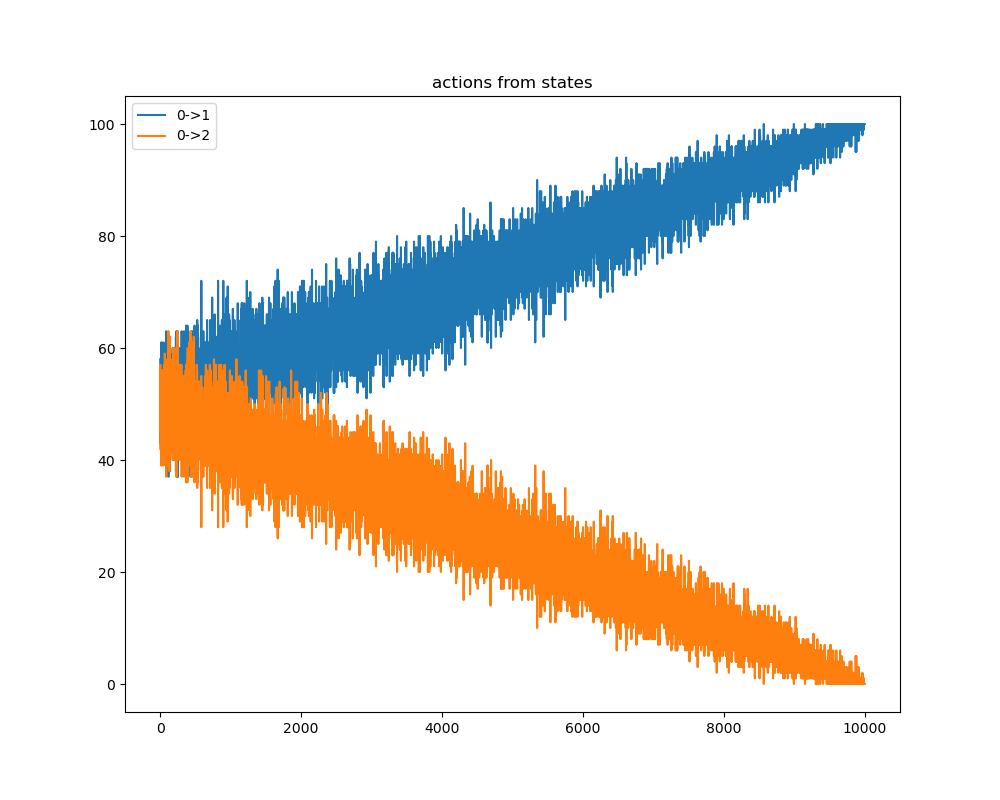

In [202]:
plt.figure(figsize=(10, 8))
plt.plot([data[i]["A"][0] for i in data.keys()], label=["0->1", "0->2"])
# plt.plot([data[i]["A"][1] for i in data.keys()], label=["1->2", "1->3"])
# plt.plot([data[i]["A"][2][0] for i in data.keys()], label="2->3")
plt.title("actions from states")
plt.legend()

<IPython.core.display.Javascript object>


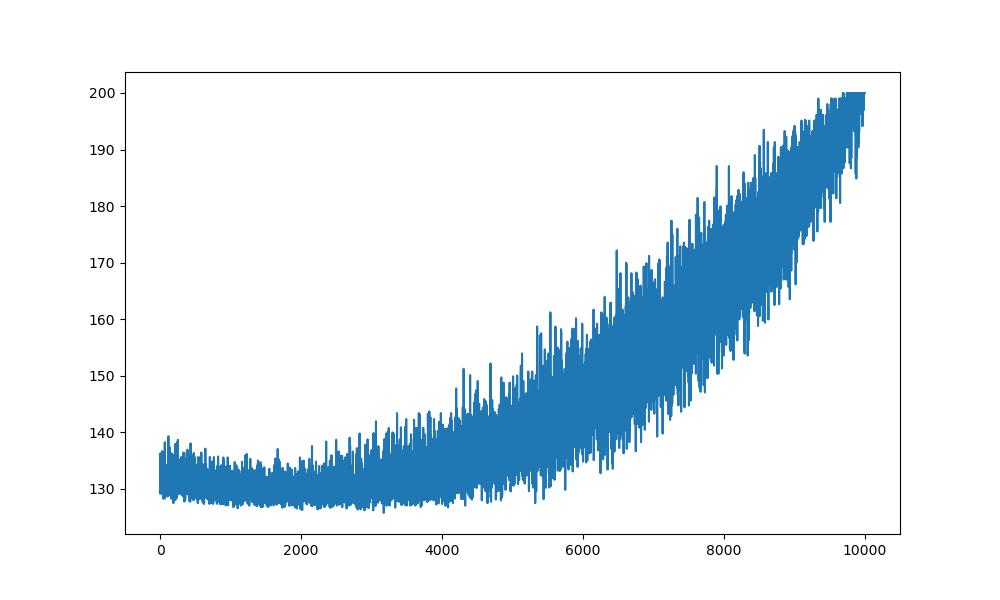

In [200]:
plt.figure(figsize=(10,6))
plt.plot([data[i]["T"].mean() for i in data.keys()])

## Try Using One NN

In [46]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [47]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
#         print("forward", x.shape)
#         x = x.T
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [48]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
#         print("forward", x.shape)
#         x = x.T
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Sandbox ...

In [57]:
%load_ext line_profiler

In [60]:
def fun():
    # BATCH_SIZE is the number of transitions sampled from the replay buffer
    # GAMMA is the discount factor as mentioned in the previous section
    # EPS_START is the starting value of epsilon
    # EPS_END is the final value of epsilon
    # EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
    # TAU is the update rate of the target network
    # LR is the learning rate of the AdamW optimizer
    BATCH_SIZE = 10
    GAMMA = 0
    EPS_START = 0.9
    EPS_END = 0.05
    EPS_DECAY = 100
    TAU = 0.005
    LR = 1e-4

    # Get number of actions from gym action space
    n_actions = 2
    # Get the number of state observations
    state, info = torch.Tensor([0,0]), _  # env.reset()
    n_observations = 2  # state space

    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())  # not sure what this is for

    optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)  
    memory = ReplayMemory(10000)


    steps_done = 0


    def select_action(state):  # epsilon greedy action selection, perfect
        global steps_done
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)  # epsilon is decayed manually
        steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return the largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return policy_net(state).max(-1)[1].view(1, 1)  # changed max(1) to max(0) fixing bug
        else:
            return torch.tensor([np.random.randint(n_actions)], device=device, dtype=torch.long)


    episode_durations = []


    def plot_durations(show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(episode_durations, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())

    def optimize_model():
        if len(memory) < BATCH_SIZE:
            return
        transitions = memory.sample(BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                              batch.next_state)), device=device, dtype=torch.bool)

    #     print(batch)

        non_final_next_states = torch.stack([s for s in batch.next_state 
                                           if s is not None])

    #     print("batch.next_state", batch.next_state)
    #     print("nfns,", non_final_next_states)
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

    #     print(state_batch, action_batch)
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
        optimizer.step()

    n_agents = 1
    n_actions = 2
    n_states = 4
    n_iter = 100

    G = nx.DiGraph()
    G.add_nodes_from([0, 1, 2, 3])
    G.add_edges_from([
        (0, 1, {"cost": lambda x: x}), 
        (0, 2, {"cost": lambda x: 100}),
        (1, 2, {"cost": lambda x: 0}),
        (1, 3, {"cost": lambda x: 100}),
        (2, 3, {"cost": lambda x: x})])

    positions = {0: (0, 1), 1: (1,2), 2: (1,0), 3: (2,1)}

    state_binary = {
        0: np.array([0,0]),
        1: np.array([0,1]),
        2: np.array([1,0]),
        3: np.array([1,1])}

    data = {}

    for t in range(n_iter):
    #     print(t)
        T = np.zeros(n_agents)
        S = np.zeros(n_agents).astype(int)
        actions_taken = np.zeros((n_states, n_actions))
        trajectory = []

        state, info = state_binary[0], _  # env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device)  #.unsqueeze(0)

    #     print(state)

        while np.where(S==3, False, True).sum() > 0:
            remaining_agents = np.where(S!=3, True, False)
            next_agents = np.where(T == T[remaining_agents].min(), True, False)

            uni = np.unique(S[next_agents])

            for s in uni:
                if s == 3:
                    # terminate
                    pass
                else:    
                    edges = [neighbour[1] for neighbour in G.edges(s)]

                    agents_at_s = np.where(S==s, True, False) * next_agents

        #                 A = e_greedy_select_action(Q[agents_at_s], S[agents_at_s], epsilons[t])
                    A = select_action(state)

        #                 print(A)

                    A = np.clip(A.flatten(), 0, len(edges)-1)

        #                 print(A)

                    counts = np.bincount(A, minlength=n_actions)

                    actions_taken[s] += counts
        #                 print(actions_taken)
                    rewards = [G.adj[s][neighbour[1]]["cost"](counts[i]) for i,neighbour in enumerate(G.edges(s))]
    #                 print("rewards", rewards)
    #                 print("actions", A)

                    R = np.array([rewards[a] for a in A])

        #                 r_average = np.array(rewards).mean()
        #                 R = np.array([r_average for a in A])

                    S[agents_at_s] = np.array([edges[a] for a in A]).astype(int)

                    observation = state_binary[np.array([edges[a] for a in A]).astype(int)[0]]  # hack to have 2 dims
                    action = A
                    reward = -R[0]
                    terminated = True if s == 3 else False
                    truncated = False

                    if t > 9990:
                        print("s", state, "a", action, "r", reward, "s'", observation)

                    reward = torch.tensor([reward], device=device)
                    done = terminated or truncated
                    if terminated:
                        next_state = None
                    else:
                        next_state = torch.tensor(observation, dtype=torch.float32, device=device)  #.unsqueeze(0)

                    # Store the transition in memory
                    state = state.unsqueeze(0)
                    action = action[:, None] # torch.tensor(A, dtype=torch.int64, device=device).unsqueeze(0)
                    memory.push(state, action, next_state, reward)

                    # Move to the next state
                    state = next_state

                    # Perform one step of the optimization (on the policy network)
                    optimize_model()

                    T[agents_at_s] += R

                    trajectory.append(tuple([s, counts, rewards, edges]))

                    # Soft update of the target network's weights
                    # θ′ ← τ θ + (1 −τ )θ′
                    target_net_state_dict = target_net.state_dict()
                    policy_net_state_dict = policy_net.state_dict()
                    for key in policy_net_state_dict:
                        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                    target_net.load_state_dict(target_net_state_dict)

                    if done:
                        episode_durations.append(t + 1)
                        plot_durations()
                        break

        ## SAVE PROGRESS DATA[agents]
        data[t] = {
            "T": T,
            "S": S,
    #         "Q": copy.deepcopy(Q),
    #         "amax": Q[:,0].mean(axis=0).argmax(),
            "A": actions_taken,
            "trajectory": trajectory 
                   }
    return data

In [63]:
%prun fun()

In [178]:
policy_net(torch.tensor(np.array([1,0]), dtype=torch.float32, device=device).unsqueeze(0))

tensor([[  -1.0003, -108.1805]], grad_fn=<AddmmBackward0>)

In [185]:
select_action(torch.tensor(np.array([0,1]), dtype=torch.float32, device=device).unsqueeze(0))

tensor([[0]])

<IPython.core.display.Javascript object>


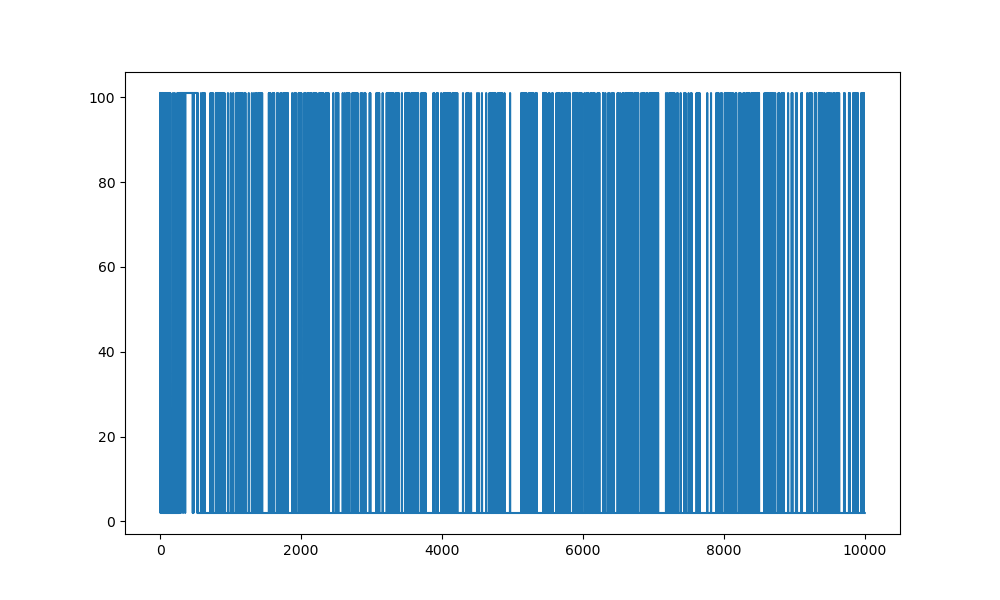

In [188]:
%matplotlib notebook
plt.figure(figsize=(10,6))
plt.plot([data[i]["T"].mean() for i in data.keys()])

# Try Using 1 NN for all agents 

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 10
GAMMA = 0
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = 2
# Get the number of state observations
state, info = torch.Tensor([0,0]), _  # env.reset()
n_observations = 2  # state space

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())  # not sure what this is for

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)  
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):  # epsilon greedy action selection, perfect
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)  # epsilon is decayed manually
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(-1)[1].view(1, 1)  # changed max(1) to max(0) fixing bug
    else:
        return torch.tensor([np.random.randint(n_actions)], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    
#     print(batch)
    
    non_final_next_states = torch.stack([s for s in batch.next_state 
                                       if s is not None])

#     print("batch.next_state", batch.next_state)
#     print("nfns,", non_final_next_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
#     print(state_batch, action_batch)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

n_agents = 100
n_actions = 2
n_states = 4
n_iter = 10

G = nx.DiGraph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([
    (0, 1, {"cost": lambda x: x}), 
    (0, 2, {"cost": lambda x: 100}),
    (1, 2, {"cost": lambda x: 0}),
    (1, 3, {"cost": lambda x: 100}),
    (2, 3, {"cost": lambda x: x})])

positions = {0: (0, 1), 1: (1,2), 2: (1,0), 3: (2,1)}

state_binary = {
    0: np.array([0,0]),
    1: np.array([0,1]),
    2: np.array([1,0]),
    3: np.array([1,1])}

data = {}

for t in range(n_iter):
#     print(t)
    T = np.zeros(n_agents)
    S = np.zeros(n_agents).astype(int)
    actions_taken = np.zeros((n_states, n_actions))
    trajectory = []
    
    state, info = state_binary[0], _  # env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device)  #.unsqueeze(0)
    
#     print(state)
    
    while np.where(S==3, False, True).sum() > 0:
        remaining_agents = np.where(S!=3, True, False)
        next_agents = np.where(T == T[remaining_agents].min(), True, False)

        uni = np.unique(S[next_agents])

        for s in uni:
            if s == 3:
                # terminate
                pass
            else:    
                edges = [neighbour[1] for neighbour in G.edges(s)]

                agents_at_s = np.where(S==s, True, False) * next_agents

    #                 A = e_greedy_select_action(Q[agents_at_s], S[agents_at_s], epsilons[t])
                A = select_action(state)

    #                 print(A)

                A = np.clip(A.flatten(), 0, len(edges)-1)

    #                 print(A)

                counts = np.bincount(A, minlength=n_actions)

                actions_taken[s] += counts
    #                 print(actions_taken)
                rewards = [G.adj[s][neighbour[1]]["cost"](counts[i]) for i,neighbour in enumerate(G.edges(s))]
#                 print("rewards", rewards)
#                 print("actions", A)

                R = np.array([rewards[a] for a in A])

    #                 r_average = np.array(rewards).mean()
    #                 R = np.array([r_average for a in A])

                S[agents_at_s] = np.array([edges[a] for a in A]).astype(int)

                observation = state_binary[np.array([edges[a] for a in A]).astype(int)[0]]  # hack to have 2 dims
                action = A
                reward = -R[0]
                terminated = True if s == 3 else False
                truncated = False
                
                if t > 9990:
                    print("s", state, "a", action, "r", reward, "s'", observation)
                
                reward = torch.tensor([reward], device=device)
                done = terminated or truncated
                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(observation, dtype=torch.float32, device=device)  #.unsqueeze(0)

                # Store the transition in memory
                state = state.unsqueeze(0)
                action = action[:, None] # torch.tensor(A, dtype=torch.int64, device=device).unsqueeze(0)
                memory.push(state, action, next_state, reward)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                optimize_model()

                T[agents_at_s] += R

                trajectory.append(tuple([s, counts, rewards, edges]))

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                target_net.load_state_dict(target_net_state_dict)

                if done:
                    episode_durations.append(t + 1)
                    plot_durations()
                    break

    ## SAVE PROGRESS DATA[agents]
    data[t] = {
        "T": T,
        "S": S,
#         "Q": copy.deepcopy(Q),
#         "amax": Q[:,0].mean(axis=0).argmax(),
        "A": actions_taken,
        "trajectory": trajectory 
               }

### Open Street Map Sandbox

In [87]:
!pip install osmnx

     |████████████████████████████████| 93 kB 3.1 MB/s eta 0:00:011
  Using cached numpy-1.24.2-cp39-cp39-macosx_10_9_x86_64.whl (19.8 MB)
     |████████████████████████████████| 8.4 MB 38.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 61.6 MB/s eta 0:00:01
  Using cached pandas-1.5.3-cp39-cp39-macosx_10_9_x86_64.whl (12.0 MB)
     |████████████████████████████████| 1.4 MB 63.2 MB/s eta 0:00:01
     |████████████████████████████████| 18.3 MB 68.6 MB/s eta 0:00:01
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.2
    Uninstalling pandas-1.4.2:
      Successfully uninstalled pandas-1.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depen

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


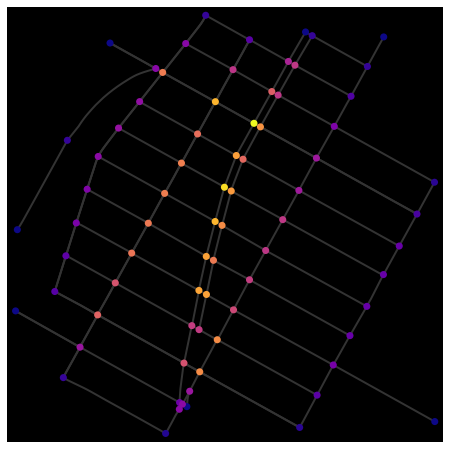

/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/osmnx/io.py:87: UserWarning: The `save_graph_shapefile` function is deprecated and will be removed in a future release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis.
  warnings.warn(
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/osmnx/io.py:114: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)
/Users/ccarissimo/opt/miniconda3/envs/sim/lib/python3.9/site-packages/osmnx/io.py:115: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_edges.to_file(filepath_edges, driver="ESRI Shapefile", index=True, encoding=encoding)


In [6]:
import osmnx as ox

ox.config(use_cache=True, log_console=True)

# download street network data from OSM and construct a MultiDiGraph model
G = ox.graph_from_point((40.78172133353491, -73.98089508177232), dist=500, network_type="drive")
# G = ox.graph_from_place("Brooklyn, USA")
# G = ox.graph_from_place("Brooklyn, USA", network_type="drive")

# impute edge (driving) speeds and calculate edge traversal times
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

# you can convert MultiDiGraph to/from geopandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
G = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

# convert MultiDiGraph to DiGraph to use nx.betweenness_centrality function
# choose between parallel edges by minimizing travel_time attribute value
D = ox.utils_graph.get_digraph(G, weight="travel_time")

# calculate node betweenness centrality, weighted by travel time
bc = nx.betweenness_centrality(D, weight="travel_time", normalized=True)
nx.set_node_attributes(G, values=bc, name="bc")

# plot the graph, coloring nodes by betweenness centrality
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G, bgcolor="k", node_color=nc, node_size=50, edge_linewidth=2, edge_color="#333333"
)

# save graph to shapefile, geopackage, or graphml
ox.save_graph_shapefile(G, filepath="./graph_shapefile/")
ox.save_graph_geopackage(G, filepath="./graph.gpkg")
ox.save_graphml(G, filepath="./graph.graphml")

In [7]:
G.nodes()

NodeView((42421769, 42443347, 42421772, 42442469, 42421775, 1061531525, 42428653, 42421776, 42431024, 42431019, 42421778, 42422592, 42441587, 7912855687, 42428072, 42423070, 42424032, 42431004, 42432572, 42425188, 42428061, 42438859, 42428063, 42442463, 42428065, 1061531803, 42428648, 42428068, 42431015, 42438867, 42428634, 1061531448, 6207264908, 42428637, 42431005, 42428640, 1061531500, 42428643, 42431008, 42428645, 1061531566, 1061531454, 42428657, 42428661, 1061531818, 42431000, 42442422, 42431002, 595245883, 42431007, 42441670, 42431009, 42432558, 42443336, 42432564, 42442445, 1061531757, 42441654, 42433567, 42437305, 42438862, 42443346, 1061531695, 42441668, 9177424867, 42443341, 42442451, 1061531634, 42442459, 1061531645, 42435283, 42443344, 61269797, 1061531491, 1996323622, 9177424868))

In [8]:
len(G.nodes)

76

In [9]:
G.adj[42467437][42517539]

KeyError: 42467437

In [12]:
from networkx import grid_graph
G = grid_graph(dim=(8,8))
len(G)

64

In [13]:
G.nodes()

NodeView(((0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)))

In [14]:
G.edges()

EdgeView([((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((0, 2), (0, 3)), ((0, 3), (1, 3)), ((0, 3), (0, 4)), ((0, 4), (1, 4)), ((0, 4), (0, 5)), ((0, 5), (1, 5)), ((0, 5), (0, 6)), ((0, 6), (1, 6)), ((0, 6), (0, 7)), ((0, 7), (1, 7)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((1, 2), (1, 3)), ((1, 3), (2, 3)), ((1, 3), (1, 4)), ((1, 4), (2, 4)), ((1, 4), (1, 5)), ((1, 5), (2, 5)), ((1, 5), (1, 6)), ((1, 6), (2, 6)), ((1, 6), (1, 7)), ((1, 7), (2, 7)), ((2, 0), (3, 0)), ((2, 0), (2, 1)), ((2, 1), (3, 1)), ((2, 1), (2, 2)), ((2, 2), (3, 2)), ((2, 2), (2, 3)), ((2, 3), (3, 3)), ((2, 3), (2, 4)), ((2, 4), (3, 4)), ((2, 4), (2, 5)), ((2, 5), (3, 5)), ((2, 5), (2, 6)), ((2, 6), (3, 6)), ((2, 6), (2, 7)), ((2, 7), (3, 7)), ((3, 0), (4, 0)), ((3, 0), (3, 1)), ((3, 1), (4, 1)), ((3, 1), (3, 2)), ((3, 2), (4, 2)), ((3, 2), (3, 3)), ((3, 3), (4, 3)), ((3, 3), (3, 4)), ((3, 4), (4, 4)), ((3, 4), (3, 5)), 

In [20]:
G.edges((0,0))

EdgeDataView([((0, 0), (1, 0)), ((0, 0), (0, 1))])

In [27]:
for e in G.edges():
    G.edges[e]["cost"] = lambda x: 10 + x

In [23]:
G.edges[(0,0), (1,0)]["attr"] = 1

In [24]:
G.edges[(0,0), (1,0)]["attr"]

1

In [ ]:
for node in G.nodes:
    d = G.adj[node]
    action_map = {i: n for i,n in enumerate(d)}
    G.nodes[node]["action_map"] = action_map

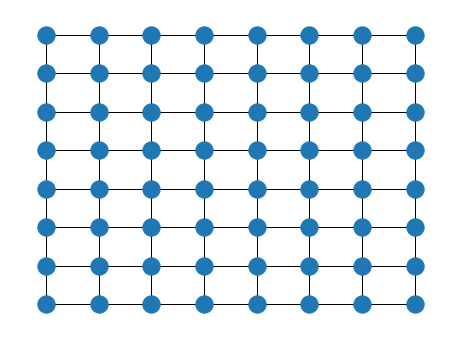

In [39]:
positions = {node: node for node in G.nodes()}
fig, ax = plt.subplots(figsize=(8,6))
nx.draw(G, pos=positions, ax=ax)
# nx.draw_networkx_edges(G, ax=ax)
# nx.draw_networkx_nodes(G, ax=ax)
# nx.draw_networkx_edge_labels(G, pos=positions, ax=ax, 
#                             edge_labels={
#                                 (0, 1): "0", 
#                                 (0, 2): "1",
#                                 (1, 2): "0",
#                                 (1, 3): "1",
#                                 (2, 3): "0",
#                                 (2, 4): "1",
#                                 (4, 3): "0"
#                             }, font_color="red")
# nx.draw_networkx_labels(G, pos=positions, ax=ax, font_color="white")

In [48]:
one_hot_enc = {(l,r): np.concatenate([np.array([0 if i!=l else 1 for i in range(8)]), np.array([0 if i!=r else 1 for i in range(8)])]) for (l,r) in G.nodes()}

In [40]:
l = 2
r = 3

In [46]:
np.concatenate([np.array([0 if i!=l else 1 for i in range(8)]), np.array([0 if i!=r else 1 for i in range(8)])])

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [50]:
np.concatenate([np.array([0,0,0])])

array([0, 0, 0])

In [54]:
S = np.zeros((10, 2)).astype(int)  # two dim, for two dim states
final_states = np.random.randint(0, 7, size=(10, 2))

In [62]:
remaining_agents = np.where((S != final_states).any(axis=1), True, False)

In [63]:
remaining_agents

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [68]:
tuple(np.array([0,1]))

(0, 1)

In [75]:
np.random.randint(1)

0